# Проект: Прогнозирование температуры звезды

__Заказчик__: обсерватория «Небо на ладони».

__Цель проекта__: разработка нейронной сети, которая поможет предсказывать абсолютную температуру на поверхности звезды.

__Описание данных__: характеристики уже изученных 240 звёзд.

_Характеристики_:
- относительная светимость L/Lo — светимость звезды относительно Солнца
- относительный радиус R/Ro — радиус звезды относительно радиуса Солнца
- абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды
- звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа
- тип звезды

    Номер, соответствующий типу:
    - коричневый карлик	0
    - красный карлик	1
    - белый карлик	2
    - звёзды главной последовательности	3
    - сверхгигант	4
    - гипергигант	5
- абсолютная температура T(K) — температура на поверхности звезды в Кельвинах

__Оценка модели__:
- метрика RMSE (не должна превышать 4500).

## Подготовка

In [ ]:
#!pip install -q phik

In [ ]:
#!pip install -q scikit-learn==1.1.3 

In [ ]:
import itertools
import random
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from phik import phik_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# константы
TITLE_SIZE = 18
LABEL_SIZE = 16
RANDOM_STATE = 42

In [ ]:
# для воспроизводимости результатов
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

## Загрузка данных

In [ ]:
data = pd.read_csv('/datasets/data_stars.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


In [7]:
data.head(10)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
5,5,2840,0.000650,0.1100,16.98,0,Red
6,6,2637,0.000730,0.1270,17.22,0,Red
7,7,2600,0.000400,0.0960,17.40,0,Red
8,8,2650,0.000690,0.1100,17.45,0,Red
9,9,2700,0.000180,0.1300,16.05,0,Red


In [8]:
# удаляем неинформативный столбец (содержит номера записей)
data = data.drop(['Unnamed: 0'], axis=1)

In [9]:
data = data.rename(columns={'Temperature (K)': 'temperature',
                            'Luminosity(L/Lo)': 'luminosity',
                            'Radius(R/Ro)': 'radius',
                            'Absolute magnitude(Mv)': 'magnitude',
                            'Star type': 'star_type',
                            'Star color': 'star_color'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  240 non-null    int64  
 1   luminosity   240 non-null    float64
 2   radius       240 non-null    float64
 3   magnitude    240 non-null    float64
 4   star_type    240 non-null    int64  
 5   star_color   240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


__Промежуточный вывод__:
- загрузили датасет, удалили столбец, содержащий номера строк;
- данные соотвествуют описанию, пропуски отсутствуют, типы данных определены верно, названия столбцов приведены к змеиному регистру.

## Предобработка данных

In [10]:
data.describe()

,temperature,luminosity,radius,magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [11]:
data['star_type'].unique()

array([0, 1, 2, 3, 4, 5])

Явных аномалий в числовых данных нет. Поработаем с неявными дубликатами. 

In [12]:
data['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [13]:
data['star_color'] = (
    data['star_color']
    .str.strip()
    .str.lower()
    .str.replace('-', ' '))
grouped_data = (
    data
    .groupby('star_color')
    .agg(count=('star_color', 'count'),
         median_temperature=('temperature', 'median')))
grouped_data.sort_values('median_temperature', ascending=False)

,count,median_temperature
star_color,,
blue,56,19921.5
blue white,41,14100.0
yellowish white,3,11790.0
white,10,8879.5
whitish,2,8876.0
pale yellow orange,1,7230.0
white yellow,1,7100.0
yellow white,8,6158.0
orange red,1,5112.0


> __Справочно:__ Подавляющее большинство звёзд может быть отнесено к одному из основных классов: O, B, A, F, G, K, M. В таком порядке эти классы образуют непрерывную последовательность по уменьшению эффективной температуры звезды и по цвету — от голубых к красным.

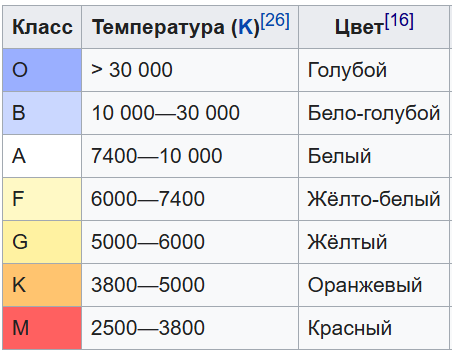

Приведем список цветов к списку основных значений, используемых при спектральной классификации звезд:
- blue
- blue white
- white
- yellow white
- yellow
- orange
- red

Отметим, что в предоставленном датасете медианная температура не всегда соответствует таблице. В первую очереь будем ориентироваться на цвет при изменении названий.

In [14]:
data['star_color'] = data['star_color'].replace({
    'white yellow': 'yellow white',
    'yellowish white': 'white', # ближе к белому по температуре
    'whitish': 'white',
    'orange red': 'orange',
    'yellowish': 'yellow',
    'pale yellow orange': 'yellow white'       
})
grouped_data = (
    data
    .groupby('star_color')
    .agg(count=('star_color', 'count'),
         median_temperature=('temperature', 'median')))
grouped_data.sort_values('median_temperature', ascending=False)

,count,median_temperature
star_color,,
blue,56,19921.5
blue white,41,14100.0
white,15,8930.0
yellow white,10,6568.5
yellow,3,4526.0
orange,3,4287.0
red,112,3324.0


Выполним проверку на дубликаты.

In [15]:
data.duplicated().sum()

0

Дубликаты не обнаружены.

__Промежуточный вывод__: 
- дубликаты не обнаружены;
- названия цветов (признак 'star_color') приведены к нижнему регистру, удалены пробелы из начала и конца строки, символ '-' заменен на ' ', все данные сведены к основым цветам.

## Исследовательский анализ данных

In [16]:
def analyze_numerical_data(data, column, title, bins_number=100):
    """
    Функция помогает при проведении статистического анализа количественных признаков.

    Принимает датасет, столбец для анализа и значение заголовка для вывода графика.
    Может принимать bins для построения графика.

    Выводит для колонки:
    - гистограмму с отмеченным средним значением и медианой
    - диаграмму размаха
    """

    print(data[column].describe())
     
    median = data[column].median()
    mean = data[column].mean()
        
    # Создаем фигуру и оси для гистограммы
    fig, ax = plt.subplots(2, 1, figsize=(17, 10))

    # Гистограмма
    ax[0].hist(data[column], bins=bins_number, color='skyblue')
    ax[0].set_title(f'Гистограмма для признака "{title}"', fontsize=TITLE_SIZE)
    ax[0].set_xlabel(title, fontsize=LABEL_SIZE)
    ax[0].set_ylabel('Частота', fontsize=LABEL_SIZE)
    ax[0].grid(True)
    
    ax[0].axvline(median, color='green', linestyle='dashed', linewidth=1.5, label=f'Медиана: {median:.2f}')
    ax[0].axvline(mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Среднее: {mean:.2f}')
    ax[0].legend()

    # Диаграмма размаха
    ax[1] = data[[column]].boxplot(vert=False, ax=ax[1])
    ax[1].set_title(f'Диаграмма размаха для признака "{title}"', fontsize=TITLE_SIZE)
    
    plt.tight_layout()
    # Установка вертикального отступа между графиками
    plt.subplots_adjust(hspace=0.3)
    plt.show()

Датасет содержит разные типы признаков. 

Непрерывные количественные признаки:
- относительная светимость
- относительный радиус
- абсолютная звёздная величина
- абсолютная температура (таргет)

Категориальные признаки:
- звёздный цвет 
- тип звезды

### Абсолютная температура 

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: temperature, dtype: float64


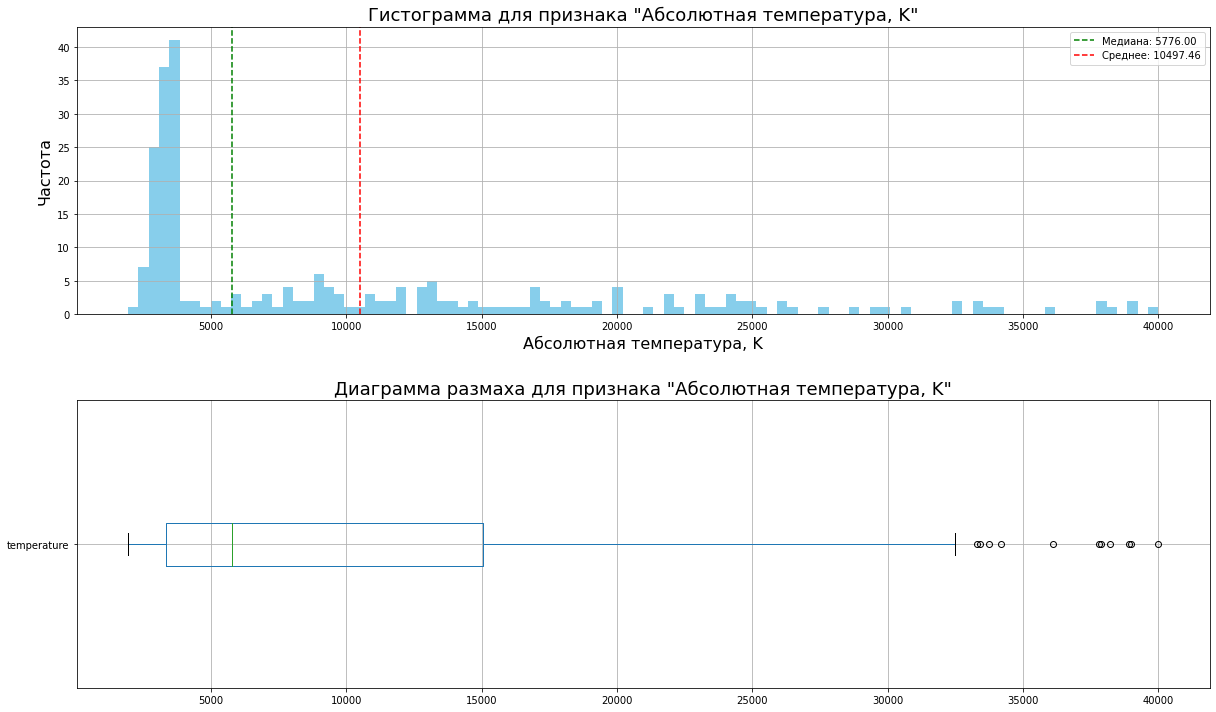

In [17]:
analyze_numerical_data(data, 'temperature', 'Абсолютная температура, K')

Целевой признак - `temperature`. Значения распределены в диапазоне от 1939 до 40000 К. Медианное значение - 5776, что в 1.8 раз меньше среднего - 10497.46. Границы межквартильного размаха - от 3344.25 до 15055.5. Стандартное отклонение - 9552.43. Значения, превышающие 32500, являются редкими.

Данные достаточно вариативны. В распределении присутствует небольшое количество звезд с высокими температурами, что увеличивает среднее значение признака.

### Относительная светимость

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: luminosity, dtype: float64


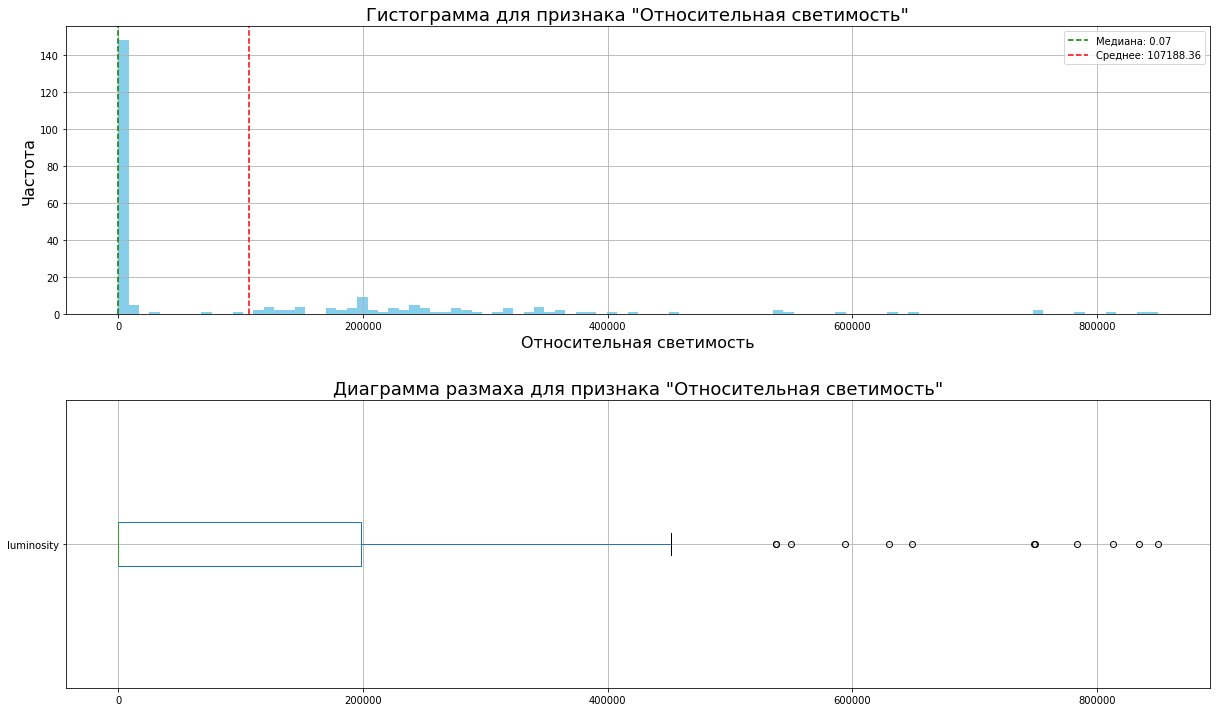

In [18]:
analyze_numerical_data(data, 'luminosity', 'Относительная светимость')

Значения признака `luminosity` распределены в диапазоне от 0 до 849420. Медианное значение - 0.07, что намного меньше среднего - 107188.36. Границы межквартильного размаха - от 0 до 198050. Стандартное отклонение - 179432.24. Присутсвуют аномально большие значения.

### Относительный радиус

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: radius, dtype: float64


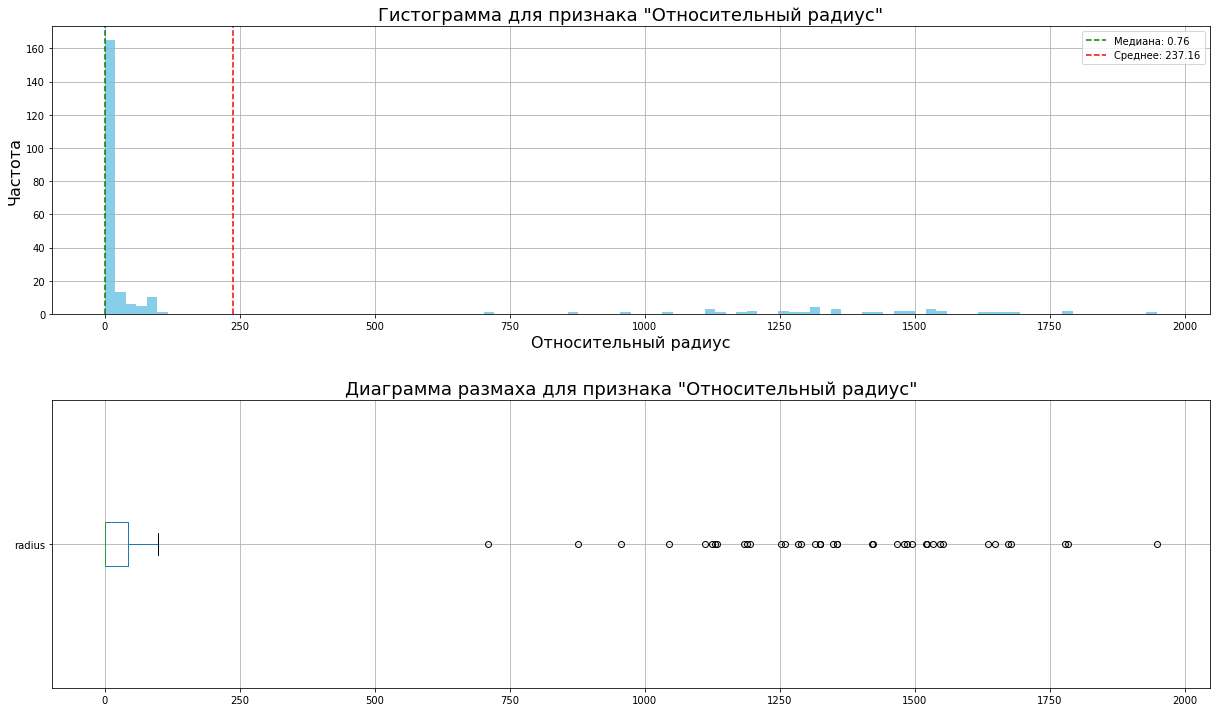

In [19]:
analyze_numerical_data(data, 'radius', 'Относительный радиус')

Значения признака `radius` распределены в диапазоне от 0.01 до 1948.5. Медианное значение - 0.76, что намного меньше среднего - 237.16. Границы межквартильного размаха - от 0.10 до 42.75. Стандартное отклонение - 517.16. Присутствуют выбросы в данных - большие значения относительного радиуса.

### Абсолютная звездная величина

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: magnitude, dtype: float64


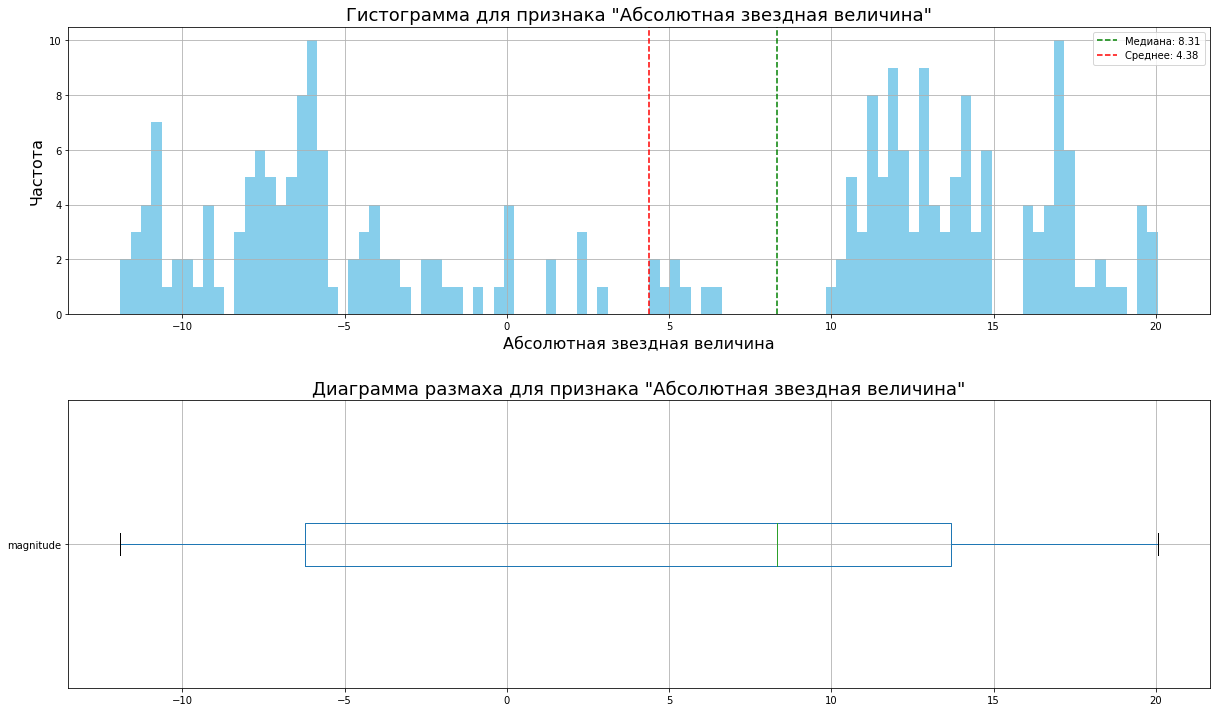

In [20]:
analyze_numerical_data(data, 'magnitude', 'Абсолютная звездная величина')

Значения признака `magnitude` распределены в диапазоне от -11.92 до 20.06. Медианное значение - 8.31, среднее -  4.38. Границы межквартильного размаха - от 0.10 до 42.75. Стандартное отклонение - 10.53. Выбросов нет. 

### Звездный цвет

In [21]:
grouped_data = (
    data
    .groupby('star_color')
    .agg(
        count=('temperature', 'count'),
        percent=('temperature', lambda x: 100*x.count()/data.shape[0]),
        median_temperature=('temperature', 'median'))
    .sort_values(by='count', ascending=False)
)
grouped_data['percent'] = grouped_data['percent'].round(2)
grouped_data.sort_values(by='median_temperature')

,count,percent,median_temperature
star_color,,,
red,112,46.67,3324.0
orange,3,1.25,4287.0
yellow,3,1.25,4526.0
yellow white,10,4.17,6568.5
white,15,6.25,8930.0
blue white,41,17.08,14100.0
blue,56,23.33,19921.5


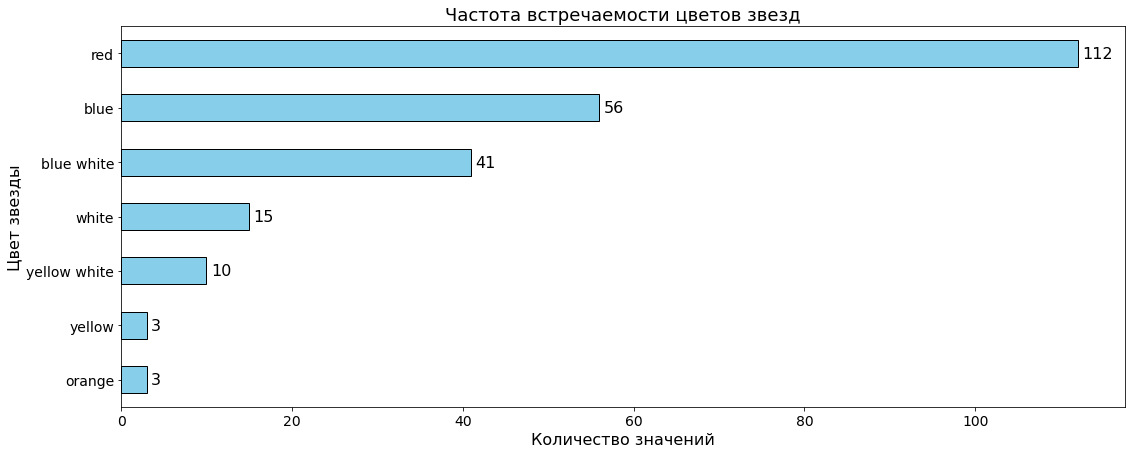

In [22]:
# построим столбчатую диаграмму
ax = grouped_data['count'].sort_values().plot.barh(
    legend=False, figsize = (18, 7), rot=0, fontsize=14,  color='skyblue', edgecolor='black')
ax.set_title('Частота встречаемости цветов звезд', fontsize = 18)
ax.set_ylabel('Цвет звезды', fontsize = LABEL_SIZE)
ax.set_xlabel('Количество значений', fontsize = LABEL_SIZE)

# выводим значения над каждым столбцом
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_width() + 0.5, p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=LABEL_SIZE)
    
plt.show()

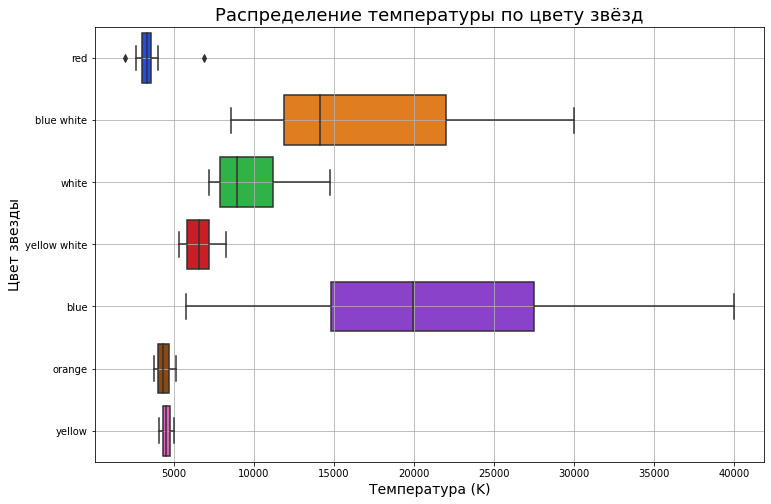

In [23]:
plt.figure(figsize=(12, 8))
sns.boxplot(y='star_color', x='temperature', data=data, palette='bright')
plt.title('Распределение температуры по цвету звёзд', fontsize=18)
plt.ylabel('Цвет звезды', fontsize=14)
plt.xlabel('Температура (K)', fontsize=14)
plt.grid(True)
plt.show()

Цвет звезд представлен 7 значениями. Больше всего данных о звездах с цветами `red`, `blue`, `blue white`. На графике видим взаимосвязь между температурой и цветом звезды. Значение медианной температуры увеличивается в зависимости от цвета: от красного к синему.

### Тип звезды

In [24]:
grouped_data = (
    data
    .groupby('star_type')
    .agg(
        count=('temperature', 'count'),
        percent=('temperature', lambda x: 100*x.count()/data.shape[0]),
        median_temperature=('temperature', 'median'))
    .sort_values(by='count', ascending=False)
)
grouped_data['percent'] = grouped_data['percent'].round(2)
grouped_data

,count,percent,median_temperature
star_type,,,
0,40,16.67,2935.0
1,40,16.67,3314.0
2,40,16.67,13380.0
3,40,16.67,12560.5
4,40,16.67,12821.0
5,40,16.67,3766.0


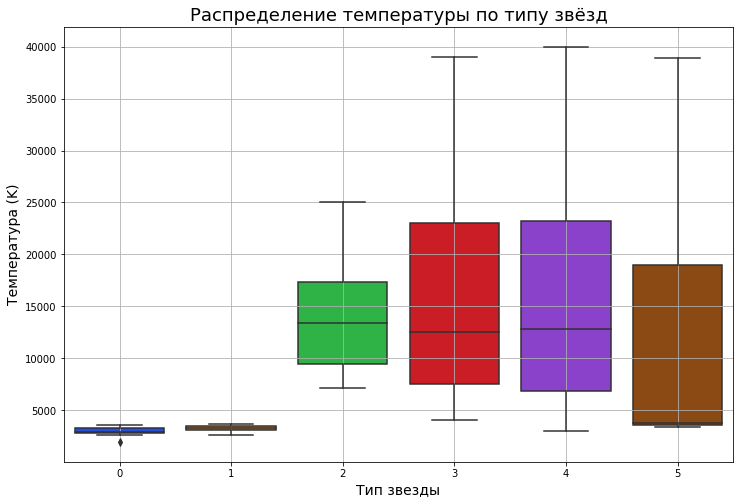

In [25]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='star_type', y='temperature', data=data, palette='bright')
plt.title('Распределение температуры по типу звёзд', fontsize=18)
plt.xlabel('Тип звезды', fontsize=14)
plt.ylabel('Температура (K)', fontsize=14)
plt.grid(True)
plt.show()

Каждый тип звезд представлен одинаковым количеством записей. Медианные значения и диапазоны значений температур звезд типов 0, 1 (коричневый карлик, красный карлик) отличаются от остальных - более низкие. Медианная температура звезд типа 5 (гипергигант) также низкая, но диапазон температур значительно шире.

Т.к. у нас имеется одинаковое число записей по каждому типу звезд, посмотрим на попарные диаграммы рассеяния. Предварительно добавим 2 новых признака (логарифмы относительной светимости и радиуса).

In [26]:
data['log_luminosity'] = data['luminosity'].apply(lambda x: np.log10(x))
data['log_radius'] = data['radius'].apply(lambda x: np.log10(x))

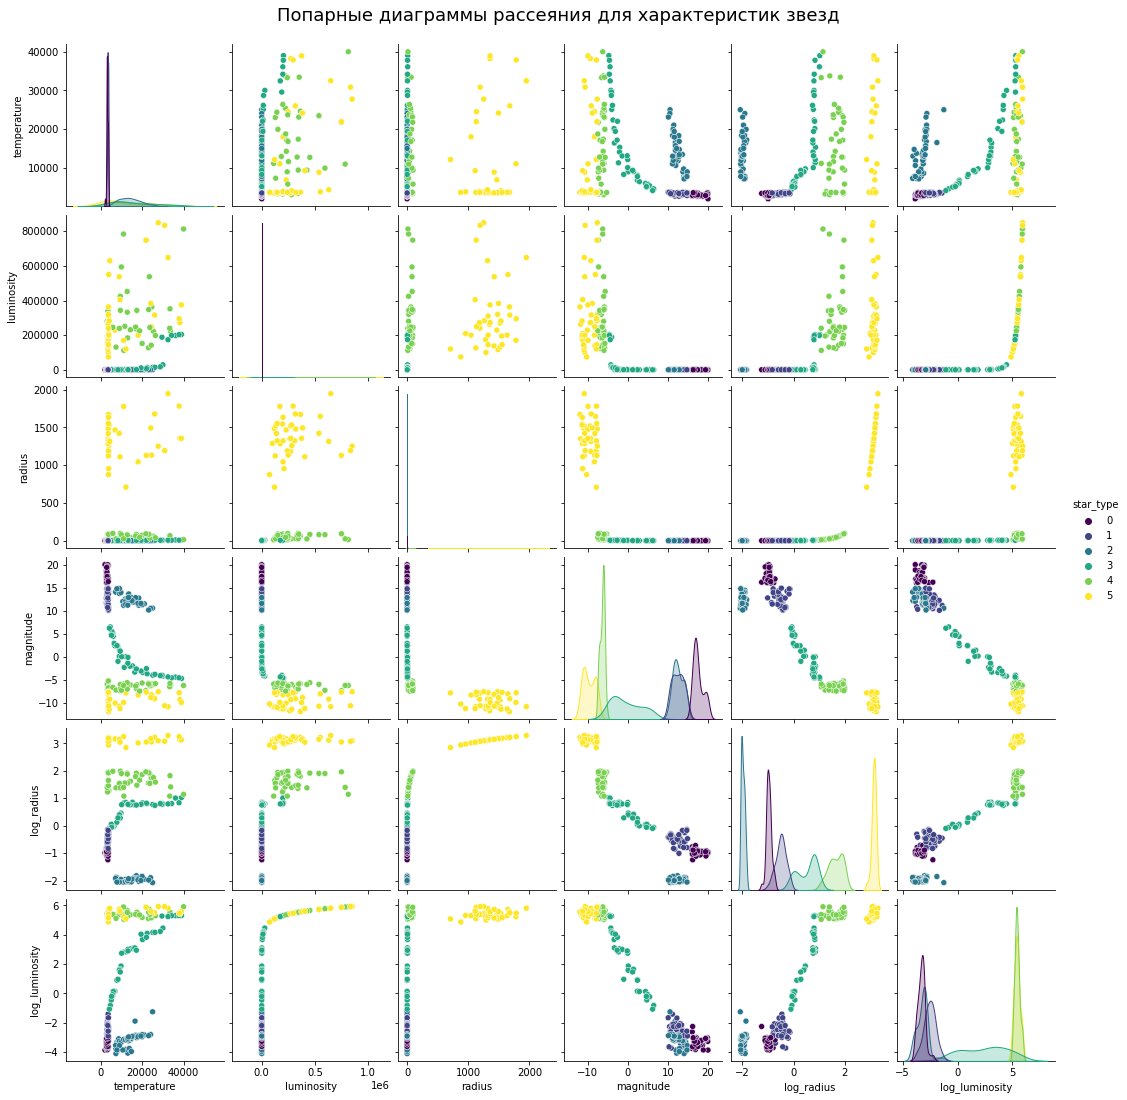

In [27]:
pair_plot = sns.pairplot(
    data, hue='star_type', 
    vars=['temperature', 'luminosity', 'radius', 'magnitude', 'log_radius', 'log_luminosity'], 
    palette='viridis')
pair_plot.fig.suptitle("Попарные диаграммы рассеяния для характеристик звезд",
                       y=1.02, fontsize=TITLE_SIZE)
plt.show()

Если посмотреть на диаграммы, можно увидеть, что для звезд 3, 4 типа наблюдается снижение температуры с ростом абсолютной звездной величины. Принимаемые значения абсолютной звездной величины уменьшаются от 0 к 5 типу звезд. Звезды 4 и 5 типа значительно превосходят другие типы по относительной светимости.

__Промежуточный вывод__:
- Значения таргета `temperature` распределены в диапазоне от 1939 до 40000 К. Медианное значение - 5776, среднее - 10497.46. Границы межквартильного размаха - от 3344.25 до 15055.5. Стандартное отклонение - 9552.43. Значения, превышающие 32500, являются редкими.
- Значения признака `luminosity` распределены в диапазоне от 0 до 849420. Медианное значение намного меньше среднего - 0.07 и 107188.36 соотвественно. Границы межквартильного размаха - от 0 до 198050. Стандартное отклонение - 179432.24. Присутсвуют аномально большие значения.
- Значения признака `radius` распределены в диапазоне от 0.01 до 1948.5. Медианное значение - 0.76, что намного меньше среднего - 237.16. Границы межквартильного размаха - от 0.10 до 42.75. Стандартное отклонение - 517.16. Присутствуют выбросы в данных - большие значения относительного радиуса.
- Значения признака `magnitude` распределены в диапазоне от -11.92 до 20.06. Медианное значение - 8.31, среднее -  4.38. Границы межквартильного размаха - от 0.10 до 42.75. Стандартное отклонение - 10.53. Выбросов нет. 
Можно сделать предположение о наличии нелинейной зависимости между температурой и значением абсолютной звездной величины.
- Цвет звезд представлен 7 значениями. Больше всего данных о звездах цвета `red`, `blue`, `blue white`. На графике видим взаимосвязь между температурой и цветом звезды. Значение медианной температуры увеличивается от красного к синему.
-  Каждый тип звезд представлен одинаковым количеством записей. Медианные значения и диапазоны значений температур звезд типов 0, 1 (коричневый карлик, красный карлик) отличаются от остальных - более низкие. Медианная температура звезд типа 5 (гипергигант) также низкая, но диапазон температур значительно шире.

## Корреляционный анализ

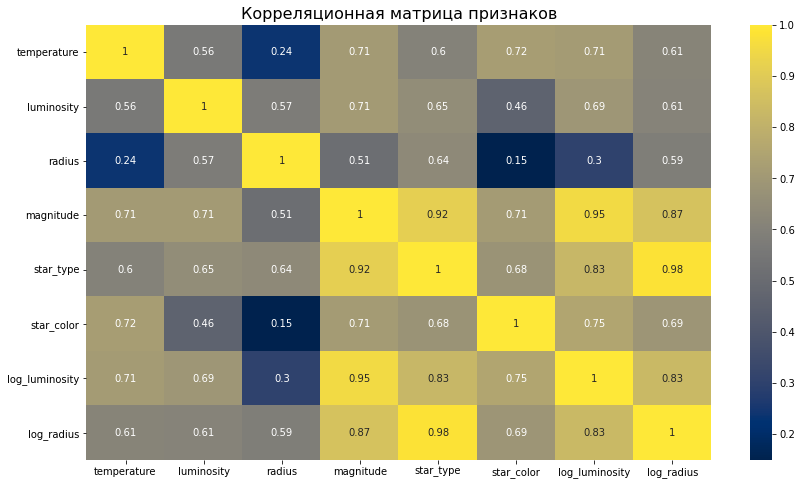

In [28]:
corr_matrix  = phik_matrix(data,
    interval_cols=['temperature', 'luminosity', 'radius', 'magnitude', 'log_radius', 'log_luminosity'])

plt.figure(figsize=(14, 8))
plt.title('Корреляционная матрица признаков', fontsize=LABEL_SIZE)
sns.heatmap(corr_matrix, annot=True, cmap='cividis');

__Промежуточный вывод__:
- корреляция Phik показывает наличие высокой взаимосвязи между таргетом и `log_luminosity`, `star_color`, `magnitude`, заметной - с признаками  `log_radius`, `star_type`, `luminosity`, умеренной - с признаком `radius`, 
- весьма высокая взаимосвязь между `star_type` и `log_radius`, `log_luminosity` и `magnitude`.

## Подготовка данных к построению моделей

In [29]:
X = data.drop(['temperature'], axis=1)
y = data['temperature']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((180, 7), (60, 7), (180,), (60,))

In [30]:
cat_col_names = ['star_type', 'star_color']
num_col_names = X_train.columns.difference(cat_col_names)

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), num_col_names), 
        ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), cat_col_names),  
    ],
    remainder='passthrough',
    n_jobs=-1
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train = torch.FloatTensor(np.array(X_train))
y_train = torch.FloatTensor(np.array(y_train))
X_test = torch.FloatTensor(np.array(X_test))
y_test = torch.FloatTensor(np.array(y_test))

## Построение базовой нейронной сети

Рассмотрим 2 полносвязные сети прямого распространения с разной архитектурой.

In [31]:
class Net1(nn.Module):
    """
    Класс нейронной сети с тремя скрытыми слоями и функциями активации LeakyReLU.

    Args:
    - n_in_neurons (int): Количество входных нейронов.
    - n_hidden_neurons_1 (int): Количество нейронов в первом скрытом слое.
    - n_hidden_neurons_2 (int): Количество нейронов во втором скрытом слое.
    - n_hidden_neurons_3 (int): Количество нейронов в третьем скрытом слое.
    - n_out_neurons (int): Количество выходных нейронов.
    - dr1 (float, optional): Коэффициент дропаута для первого скрытого слоя. По умолчанию 0.
    - dr2 (float, optional): Коэффициент дропаута для второго скрытого слоя. По умолчанию 0.
    - dr3 (float, optional): Коэффициент дропаута для третьего скрытого слоя. По умолчанию 0.
    """  

    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2,
                  n_hidden_neurons_3, n_out_neurons, dr1=0, dr2=0, dr3=0):
        
        super(Net1, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dp1 = nn.Dropout(dr1)
        self.act1 = nn.LeakyReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(dr2)
        self.act2 = nn.LeakyReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.dp3 = nn.Dropout(dr3)
        self.act3 = nn.LeakyReLU()

        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)	
        self.act4 = nn.LeakyReLU()

        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='leaky_relu') 
        nn.init.uniform_(self.fc1.bias, a=1, b=2)
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='leaky_relu') 
        nn.init.uniform_(self.fc2.bias, a=1, b=2)
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='leaky_relu') 
        nn.init.uniform_(self.fc3.bias, a=1, b=2)
        nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='leaky_relu') 
        nn.init.uniform_(self.fc4.bias, a=1, b=2)

    def forward(self, x):

        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dp2(x)

        x = self.fc3(x)
        x = self.act3(x)
        x = self.dp3(x)

        x = self.fc4(x)
        x = self.act4(x)

        return x

class Net2(nn.Module):
    """
    Класс нейронной сети с Batch Normalization.

    Args:
    - n_in_neurons (int): Количество входных нейронов.
    - n_hidden_neurons_1 (int): Количество нейронов в первом скрытом слое.
    - n_hidden_neurons_2 (int): Количество нейронов во втором скрытом слое.
    - n_out_neurons (int): Количество выходных нейронов.
    """
        
    def __init__(self, n_in_neurons, n_hidden_neurons_1, 
                 n_hidden_neurons_2, n_out_neurons):
        super(Net2, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.Tanh()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons) 
        self.act3 = nn.ReLU() 

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)

    def forward(self, x):

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        
        x = self.fc3(x)
        x = self.act3(x) 

        return x

In [32]:
def train_model(net, X_train, y_train, X_test, y_test, 
                learning_rate=0.001, num_epochs=100000, batch_size=64, printing=True, patience=5):
    """
    Обучает нейронную сеть net на обучающих данных X_train и y_train,
    используя оптимизатор Adam с learning_rate, реализовано раннее прерывание обучения.
    Перед завершением работы восстанавливается состояние модели,
    достигшей наилучшей производительности.
    
    Параметры:
        net (nn.Module): Нейронная сеть для обучения.
        X_train (torch.Tensor): Тензор входных данных для обучения.
        y_train (torch.Tensor): Тензор выходных данных для обучения.
        X_test (torch.Tensor): Тензор входных данных для тестирования.
        y_test (torch.Tensor): Тензор выходных данных для тестирования.
        learning_rate (float): Скорость обучения для оптимизатора (по умолчанию 0.001).
        num_epochs (int): Количество эпох обучения (по умолчанию 100000).
        batch_size (int): Размер батча для обучения (по умолчанию 64).
        printing (bool): Флаг для вывода информации об обучении (по умолчанию True).
        patience (int): Количество эпох без улучшения для ранней остановки (по умолчанию 5).
        
    Возвращает:
        train_loss_values (list): Список значений потерь на обучающем наборе.
        test_loss_values (list): Список значений потерь на тестовом наборе.
        epoch_count (list): Список номеров эпох.
        best_test_loss (float): Лучшее значение метрики на тестовой выборке.
    """
    
    # переменные для ранней остановки
    best_test_loss = float('inf')
    epochs_without_improvement = 0  
    
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss = nn.MSELoss()
    num_batches = ceil(len(X_train) / batch_size)
    
    # результаты обучения
    train_loss_values = []
    test_loss_values = []
    epoch_count = []
    best_model_state = None

    for epoch in range(num_epochs):

        order = np.random.permutation(len(X_train))
        
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            # Получение индексов текущего батча
            batch_indexes = order[start_index:start_index + batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net.forward(X_batch).flatten()
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test).flatten()
            mse = loss(test_preds, y_test)
            test_rmse = torch.sqrt(mse)
            train_rmse = torch.sqrt(loss_value) 
            if printing:
                print(f"Epoch: {epoch:3d} | RMSE Train Loss: {train_rmse:.5f} | RMSE Test Loss: {test_rmse:.5f}")
            epoch_count.append(epoch)
            test_loss_values.append(test_rmse.detach().numpy())
            train_loss_values.append(train_rmse.detach().numpy())

            # Ранняя остановка
            if test_rmse < best_test_loss:
                best_test_loss = test_rmse
                epochs_without_improvement = 0
                best_model_state = net.state_dict()
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                if printing:
                    print(f"Early stopping at epoch {epoch}. Best test loss: {best_test_loss:.5f}")
                break
    net.load_state_dict(best_model_state)
    return train_loss_values, test_loss_values, epoch_count, best_test_loss

In [33]:
def plot_loss(train_loss_values, test_loss_values, epoch_count):
    """
    Строит график потерь на обучающем и тестовом наборе данных по эпохам.

    Параметры:
        train_loss_values (list): Список значений потерь на обучающем наборе по эпохам.
        test_loss_values (list): Список значений потерь на тестовом наборе по эпохам.
        epoch_count (list): Список номеров эпох.

    Результат:
        Визуализация графика потерь на обучающем и тестовом наборе данных.
    """
    
    plt.figure(figsize=(9, 6))

    plt.title("Train / test loss")
    plt.xlabel("$Epoch$")
    plt.ylabel("$Loss$")

    plt.plot(epoch_count, train_loss_values)
    plt.plot(epoch_count, test_loss_values)

    plt.legend(["Train", "Test"])
    plt.show()

Выберем произвольное число нейронов для построения.

In [34]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 32
n_hidden_neurons_2 = 16 
n_hidden_neurons_3 = 8
n_out_neurons = 1

net1 = Net1(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2,
            n_hidden_neurons_3, n_out_neurons, dr1=0.2, dr2=0.2, dr3=0.2)

net2 = Net2(n_in_neurons, n_hidden_neurons_1, 
            n_hidden_neurons_2, n_out_neurons)

Epoch:   0 | RMSE Train Loss: 13752.80469 | RMSE Test Loss: 14626.38672
Epoch:  10 | RMSE Train Loss: 12472.23828 | RMSE Test Loss: 14623.21191
Epoch:  20 | RMSE Train Loss: 13249.93262 | RMSE Test Loss: 14619.63379
Epoch:  30 | RMSE Train Loss: 11234.20410 | RMSE Test Loss: 14612.93359
Epoch:  40 | RMSE Train Loss: 15114.05566 | RMSE Test Loss: 14599.87109
Epoch:  50 | RMSE Train Loss: 15679.32520 | RMSE Test Loss: 14575.73730
Epoch:  60 | RMSE Train Loss: 11269.79199 | RMSE Test Loss: 14533.63086
Epoch:  70 | RMSE Train Loss: 14931.70312 | RMSE Test Loss: 14462.76465
Epoch:  80 | RMSE Train Loss: 14501.77441 | RMSE Test Loss: 14347.93262
Epoch:  90 | RMSE Train Loss: 11000.25488 | RMSE Test Loss: 14172.87695
Epoch: 100 | RMSE Train Loss: 13812.50586 | RMSE Test Loss: 13924.21289
Epoch: 110 | RMSE Train Loss: 11645.57227 | RMSE Test Loss: 13586.25293
Epoch: 120 | RMSE Train Loss: 11941.81738 | RMSE Test Loss: 13158.57129
Epoch: 130 | RMSE Train Loss: 11083.18262 | RMSE Test Loss: 1264

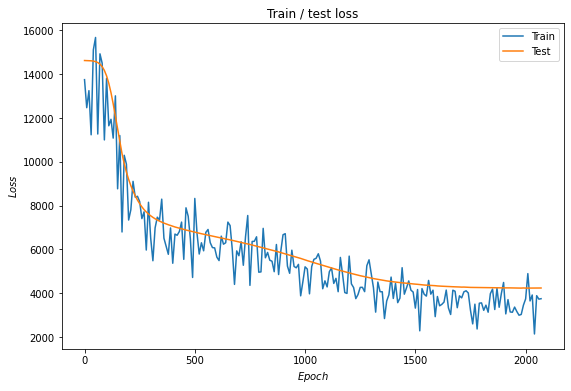

In [35]:
train_loss_values1, test_loss_values1, epoch_count1, best_test_rmse1 = train_model(
    net1, X_train, y_train, X_test, y_test, learning_rate=0.001)
plot_loss(train_loss_values1, test_loss_values1, epoch_count1)

Epoch:   0 | RMSE Train Loss: 15333.00488 | RMSE Test Loss: 14626.84375
Epoch:  10 | RMSE Train Loss: 15351.85840 | RMSE Test Loss: 14626.42773
Epoch:  20 | RMSE Train Loss: 13652.59766 | RMSE Test Loss: 14625.03125
Epoch:  30 | RMSE Train Loss: 12365.29590 | RMSE Test Loss: 14623.31738
Epoch:  40 | RMSE Train Loss: 14105.89648 | RMSE Test Loss: 14622.31738
Epoch:  50 | RMSE Train Loss: 14743.69727 | RMSE Test Loss: 14621.68066
Epoch:  60 | RMSE Train Loss: 14532.88867 | RMSE Test Loss: 14621.14453
Epoch:  70 | RMSE Train Loss: 16372.69727 | RMSE Test Loss: 14620.65430
Epoch:  80 | RMSE Train Loss: 11903.95215 | RMSE Test Loss: 14620.18750
Epoch:  90 | RMSE Train Loss: 14656.14746 | RMSE Test Loss: 14619.73730
Epoch: 100 | RMSE Train Loss: 12643.26758 | RMSE Test Loss: 14619.29980
Epoch: 110 | RMSE Train Loss: 14640.10254 | RMSE Test Loss: 14618.87109
Epoch: 120 | RMSE Train Loss: 13495.82324 | RMSE Test Loss: 14618.44727
Epoch: 130 | RMSE Train Loss: 13896.24414 | RMSE Test Loss: 1461

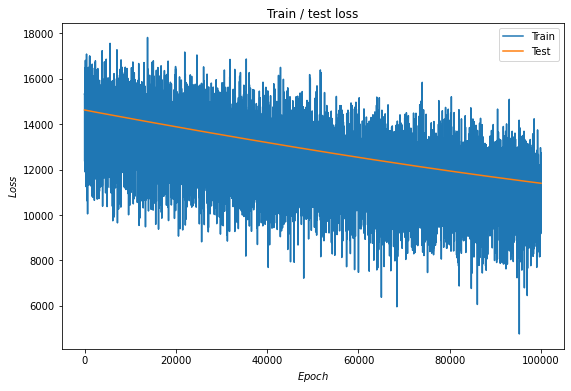

In [36]:
train_loss_values2, test_loss_values2, epoch_count2, best_test_rmse2 = train_model(
    net2, X_train, y_train, X_test, y_test, learning_rate=0.001)
plot_loss(train_loss_values2, test_loss_values2, epoch_count2)

Второй нейросети не удалось достигнуть минимума за 100000 эпох. Архитектура первой сети позволяет достигнуть нужного значения метрики даже без подбора параметров. Далее будем работать с ней. Сохраним параметры, с которыми была создана и обучалась 1 сеть в таблицу.

In [37]:
comparison_table = pd.DataFrame(
    columns=['dr1', 'dr2', 'dr3', 'learning_rate', 'batch_size', 'test RMSE', 'epochs'])
comparison_table.loc[0] = [0.2, 0.2, 0.2, 0.001, 64, best_test_rmse1.detach().numpy(), epoch_count1[-1]]
comparison_table

,dr1,dr2,dr3,learning_rate,batch_size,test RMSE,epochs
0,0.2,0.2,0.2,0.001,64,4232.0747,2070


In [38]:
def plot_real_predict_bars(preds, target):
    """
    Функция для построения гистограммы фактических и предсказанных значений.
    
    Args:
    preds (DataFrame): DataFrame с предсказанными значениями.
    target (DataFrame): DataFrame с фактическими значениями.
    """
    plt.figure(figsize=(18, 6))
    plt.bar(target.index, preds['temperature'], color='limegreen', label='Прогноз')
    plt.bar(target.index, target['temperature'], color='yellow', width=0.5, label='Факт')
    plt.legend()
    plt.title('Факт-Прогноз', fontsize=TITLE_SIZE)
    plt.xlabel('Номер звезды в таблице данных', fontsize=LABEL_SIZE)
    plt.ylabel('Температура звезды, К', fontsize=LABEL_SIZE)

    plt.show()

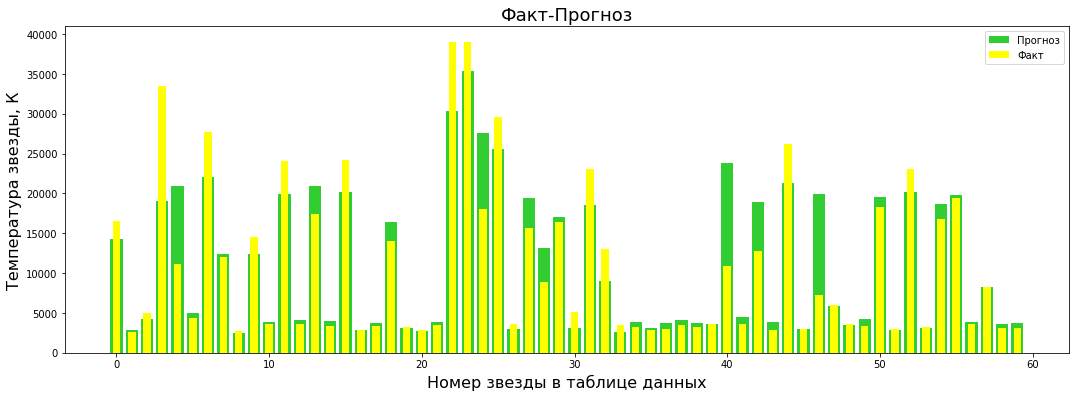

In [39]:
# Получение предсказаний для тестовой выборки
net1.eval()
test_preds = net1.forward(X_test)

test_preds = pd.DataFrame(test_preds.cpu().detach().numpy(), columns=['temperature'])
test_target = pd.DataFrame(y_test.cpu().detach().numpy(), columns=['temperature'])
plot_real_predict_bars(test_preds, test_target)

Еще на этапе анализа мы определили, что в выборке преобладают звезды с невысокими температурами. На графике видно, что модель лучше предсказывает температуру именно для таких звезд. Для самых горячих звезд температура занижается. При наличии возможности, рекомендуется расширить выборку и повторить обучение.

__Промежуточный вывод__:

- построили 2 сети с различной архитектурой и обучили их, построили графики потерь на обучающем и тестовом наборах данных;
- для дальнейшей работы выбрали сеть с тремя скрытыми слоями и функциями активации LeakyReLU;
- построили график "Факт-прогноз" для лучшей модели.

## Улучшение нейронной сети

Проведем эксперименты с разными параметрами нейросети. Архитектуру нейронной сети: количество слоёв, нейронов, вид функции активации — оставим как в Baseline.

In [40]:
# Параметры для перебора
param_grid = {
    'dr1': [0, 0.2, 0.4],
    'dr2': [0, 0.2, 0.4],
    'dr3': [0, 0.2, 0.4],
    'learning_rate': [0.01, 0.001],
    'batch_size': [32, 64, 128]
}

# Функция для перебора параметров
def grid_search(param_grid):
    """
    Выполняет поиск лучших параметров для модели на основе заданной сетки параметров.

    Параметры:
        param_grid (dict): Словарь параметров для перебора.

    Результат:
        Словари, содержащие лучшие параметры и результаты модели.
    """
        
    best_params = None
    best_test_loss = float('inf')
    best_result = None
    
    for params in itertools.product(*param_grid.values()):
        dr1, dr2, dr3, learning_rate, batch_size = params
        
        net = Net1(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, 
                   n_hidden_neurons_3, n_out_neurons, dr1, dr2, dr3)

        _, test_loss_values, epoch_count, test_rmse = train_model(
            net, X_train, y_train, X_test, y_test, 
            learning_rate=learning_rate, batch_size=batch_size, printing=False)
  
        if test_rmse < best_test_loss:
            best_test_loss = test_rmse
            best_params = {
                'dr1': dr1,
                'dr2': dr2,
                'dr3': dr3,
                'learning_rate': learning_rate,
                'batch_size': batch_size
            }
            best_result = {
                'model': net, 
                'test_rmse': test_rmse,
                'epochs': epoch_count[-1]
            }
    return best_params, best_result

# Выполнение перебора параметров
best_params, best_result = grid_search(param_grid)

print(f"Лучшие параметры: {best_params}")
print(f"Лучшая модель: {best_result['model']}, Test RMSE: {best_result['test_rmse']}, \
эпох обучения: {best_result['epochs']}")

Лучшие параметры: {'dr1': 0, 'dr2': 0, 'dr3': 0, 'learning_rate': 0.01, 'batch_size': 128}
Лучшая модель: Net1(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (dp1): Dropout(p=0, inplace=False)
  (act1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (dp2): Dropout(p=0, inplace=False)
  (act2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (dp3): Dropout(p=0, inplace=False)
  (act3): LeakyReLU(negative_slope=0.01)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
  (act4): LeakyReLU(negative_slope=0.01)
), Test RMSE: 4085.402099609375, эпох обучения: 460


In [41]:
comparison_table.loc[1] = [best_params['dr1'], best_params['dr2'],
                           best_params['dr3'], best_params['learning_rate'],
                           best_params['batch_size'], best_result['test_rmse'].detach().numpy(),
                           best_result['epochs']]

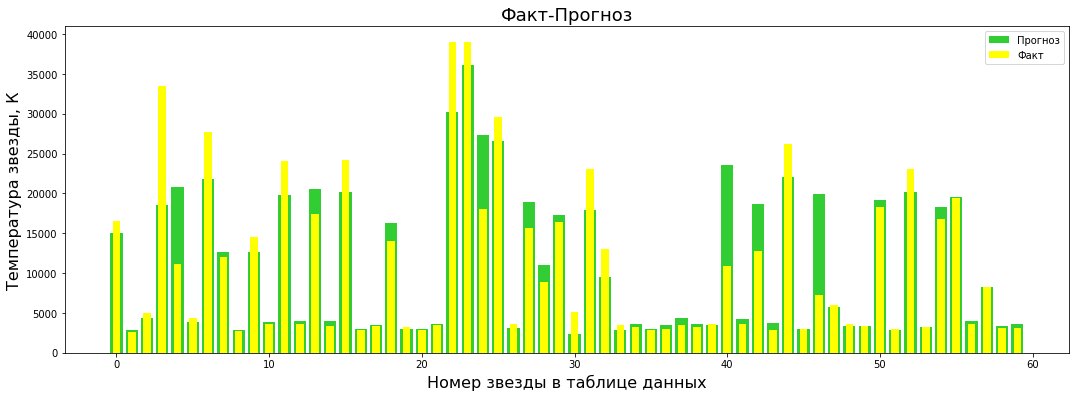

In [42]:
best_result['model'].eval()
test_preds = best_result['model'].forward(X_test)

test_preds = pd.DataFrame(test_preds.cpu().detach().numpy(), columns=['temperature'])
test_target = pd.DataFrame(y_test.cpu().detach().numpy(), columns=['temperature'])
plot_real_predict_bars(test_preds, test_target)

### Сравнительная таблица результов

In [43]:
comparison_table

,dr1,dr2,dr3,learning_rate,batch_size,test RMSE,epochs
0,0.2,0.2,0.2,0.001,64,4232.0747,2070
1,0.0,0.0,0.0,0.010,128,4085.402,460


__Промежуточный вывод__:

По результатам подбора параметров лучшей оказалась упрощенная модель: нейронная сеть, где слои дропаута выключены, скорость обучения - 0.01 и при большем размере батча (128). Модель обучалась 460 эпох и RMSE на тестовой выборке - 4085.402. 

## Выводы

Мы работали с датасетом, содержащим характеристики уже изученных 240 звёзд. 

Данные соответствовали описанию, пропусков и дубликатов нет. Названия признаков записали в змеином стиле. Названия цветов были приведены к основным 7 цветам, используемым при классификации (по уменьшению температуры звезды и по цвету).

Мы провели иследовательский анализ данных. 
Целевой признак - `temperature`. Значения распределены в диапазоне от 1939 до 40000 К. Медианное значение - 5776, среднее - 10497.46. Стандартное отклонение - 9552.43. Данные достаточно вариативны. В распределении присутствует небольшое количество звезд с высокими температурами.
Каждый тип звезд представлен одинаковым количеством записей. Цвет звезд представлен 7 значениями. Преобладают данные о звездах с цветами `red`, `blue`, `blue white`. Визуально увидели взаимосвязь между температурой и цветом звезды. Значение медианной температуры увеличивается в зависимости от цвета: от красного к синему.
Стоит отметить, что для распределений относительной светимости и относительного радиуса большинство значений сосредоточено в левой части распределения, а небольшое количество экстремально больших значений вытягивает хвост вправо. С учетом этого были добавлены новые признаки - логарифмы данных величин. В распределении абсолютной звездной величины выбросов нет. Мы построили попарные графики для признаков с учетом типов звезд. Заметили, что для звезд 3, 4 типа наблюдается снижение температуры с ростом абсолютной звездной величины. Принимаемые значения абсолютной звездной величины уменьшаются от 0 к 5 типу звезд. Звезды 4 и 5 типа значительно превосходят другие типы по относительной светимости.

Провели корреляционный анализ данных, установили наличие высокой взаимосвязи между таргетом и `log_luminosity`, `star_color`, `magnitude`, заметной - с признаками  `log_radius`, `star_type`, `luminosity`, умеренной - с признаком `radius`, весьма высокая взаимосвязь выявлена между `star_type` и `log_radius`, `log_luminosity` и `magnitude`.

Сравнили 2 полносвязные сети прямого распространения с разной архитектурой с произвольно выбранными параметрами. При обучении использовался оптимизатор Adam. Класс нейронной сети с тремя скрытыми слоями и функциями активации LeakyReLU оказался лучшим и сразу позволил получить требуемое значение метрики. Далее мы выполнили подбор гиперпараметров (значений для слоев дропаута, размер батча, коэффициент скорости обучения). 

_Baseline_: 
- 3 скрытых слоя + 3 дропаута (с параметром 0.2)
- функции активации на каждом слое: LeakyReLU()
- количество нейронов в каждом слое от входного: 16 - 32 - 16 - 8 -1
- скорость обучения: 0.001
- размер батча: 64
- эпох обучения: 2070
- RMSE на тесте: 4237.301

_Улучшенная модель_:
- 3 скрытых слоя (дропаут отключен)
- функции активации на каждом слое: LeakyReLU()
- количество нейронов в каждом слое от входного: 16 - 32 - 16 - 8 -1
- скорость обучения: 0.01
- размер батча: 128
- эпох обучения: 460
- RMSE на тесте: 4085.402

Подбор параметров позволил достичь лучшего результата: модель показывает хорошее значение метрики на тестовой выборке, быстрее достигает приемлемого уровня точности на данных.

Рекомендации по улучшению:
- добавить в датасет данные о звездах с высокими температурами, т.к. их количество слишком мало,
- расширить список гиперпараметров для выбора лучшей модели.